Совместный хакатон студентов курсов Data Science и Менеджер проектов, где они работают в командах над разработкой ML-модели для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам.

Необходимо разработать ML-продукт, который:

- Находит все кавер-треки и/или исходники к заданному треку в датасете
- Перечисляет все кавер-треки и/или оригиналы к заданному, указывает положение данного трека в цепочке каверов

### Разметка каверов

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

💡 Обратите внимание, что не для всех каверов известны идентификаторы исходных треков!!!
### Метаинформация

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

### Текст песен

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

In [2]:
!pip install -U sentence-transformers
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=499ed5f5da44e1a8521bc9555f353ac9e4a8dd4776951cc483c2baa7cc339a98
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s e

In [60]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.7 MB/s eta 0:00:00


In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sentence_transformers import util
from tqdm import notebook

from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### meta

In [5]:
meta = pd.read_json('/gdrive/MyDrive/Colab Notebooks/meta.json', lines=True)

In [6]:
meta['track_id'].duplicated().sum()

0

In [7]:
meta = meta.set_index('track_id')
meta['dttm'] = pd.to_datetime(meta['dttm'], unit='ms')

In [8]:
meta.head()

,dttm,title,language,isrc,genres,duration
track_id,,,,,,
c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0
c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0


In [9]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71769 entries, c3b9d6a354ca008aa4518329aaa21380 to 5731fc0a34c663a0c0082c712df15266
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dttm      71768 non-null  datetime64[ns]
 1   title     71768 non-null  object        
 2   language  21969 non-null  object        
 3   isrc      71455 non-null  object        
 4   genres    71768 non-null  object        
 5   duration  71768 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 3.8+ MB


In [10]:
meta = meta.drop([None])

In [11]:
meta['isrc'].duplicated().sum()

484

In [12]:
meta['genres'].value_counts().head(10)

[FOLK, LATINFOLK]    18391
[POP]                13157
[ROCK, ALLROCK]       5898
[ALTERNATIVE]         3570
[FOLK]                2645
[]                    2352
[ELECTRONICS]         2231
[SOUNDTRACK]          2181
[DANCE]               2166
[SPIRITUAL]           1552
Name: genres, dtype: int64

In [13]:
meta['language'] = meta['language'].fillna('unknown')

In [14]:
meta['genres'] = meta['genres'].apply(lambda x: ', '.join(sorted(x)))

In [15]:
meta.loc[meta['genres'] == '', 'genres'] = 'unknown'

Text(0, 0.5, 'Frequency')

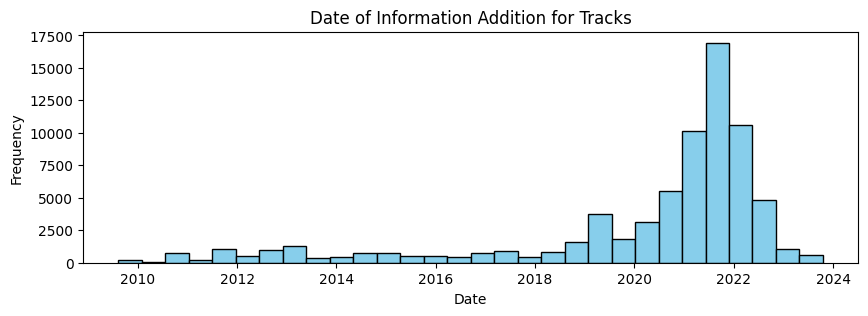

In [16]:
plt.figure(figsize=(10, 3))

plt.hist(meta['dttm'], bins=30, color='skyblue', edgecolor='black')

plt.title('Date of Information Addition for Tracks')
plt.xlabel('Date')
plt.ylabel('Frequency')

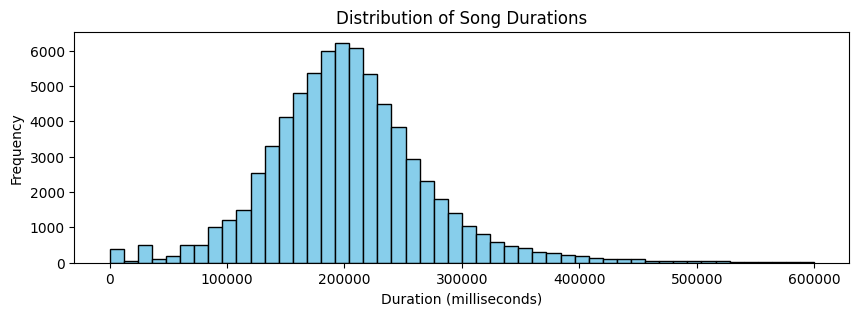

In [17]:
plt.figure(figsize=(10, 3))
plt.hist(meta['duration'], bins=50, range=(0, 600000), color='skyblue', edgecolor='black')
plt.title('Distribution of Song Durations')
plt.xlabel('Duration (milliseconds)')
plt.ylabel('Frequency')
plt.show()

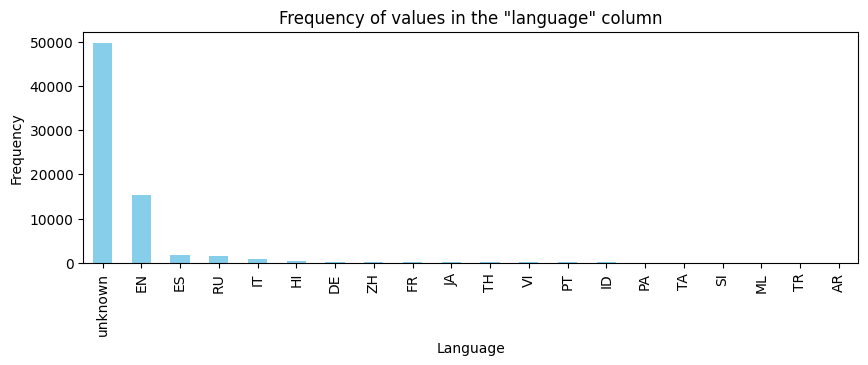

In [18]:
language_counts = meta['language'].value_counts().head(20)
plt.figure(figsize=(10, 3))
language_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of values in the "language" column')
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.show()

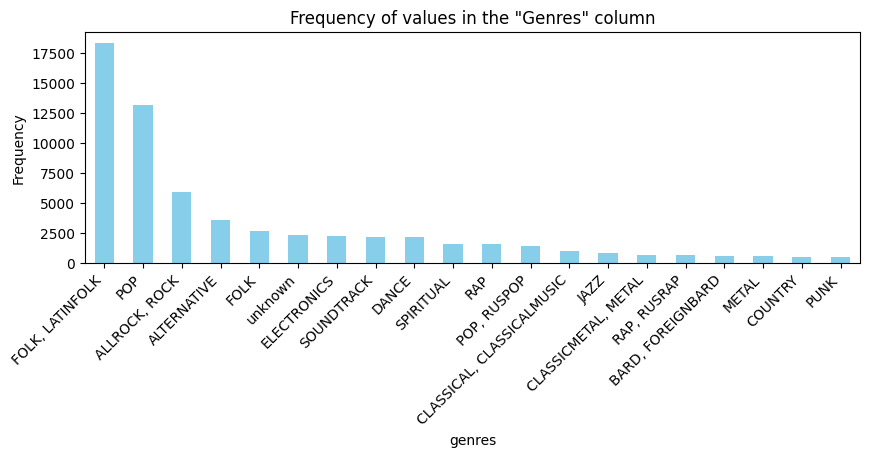

In [19]:
genre_counts = meta['genres'].value_counts().head(20)
plt.figure(figsize=(10, 3))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of values in the "Genres" column')
plt.xlabel('genres')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.xticks(ha='right')
plt.show()

## covers

In [20]:
covers = pd.read_json('/gdrive/MyDrive/Colab Notebooks/covers.json', lines=True)

In [21]:
covers['track_id'].duplicated().sum()

0

In [22]:
covers = covers.set_index('track_id')

In [23]:
covers.head()

,original_track_id,track_remake_type
track_id,,
eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
d6288499d0083cc34e60a077b7c4b3e1,None,COVER


In [24]:
covers.info();

<class 'pandas.core.frame.DataFrame'>
Index: 71597 entries, eeb69a3cb92300456b6a5f4162093851 to 7b0f6ff24137be50cf5ea5f82d789448
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_remake_type  71597 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [66]:
covers['original_track_id'] = covers['original_track_id'].fillna('unknown')

In [67]:
covers['track_remake_type'].value_counts()

COVER       67304
ORIGINAL     4293
Name: track_remake_type, dtype: int64

список самых часто повторяющихся значений в столбце covers['original_track_id']

In [68]:
covers['original_track_id'].value_counts().head(10)

unknown                             66776
f3e5e9db509f9b6f6d93b9c38e4e1324       38
17a163f6ab3de102b49599f5577866fc       32
deb9b9598176a0bab1212d430b10bd04       31
53a04991308c2cc9179fdd401fea83a3       30
9050384cce6c221c39d6e25d02561612       25
eeb69a3cb92300456b6a5f4162093851       25
8e0235cf2a39eacc4c78885ca7dd4de3       24
ad1b9fe17c16ab73b2a52920fdb1a220       19
cfcd208495d565ef66e7dff9f98764da       17
Name: original_track_id, dtype: int64

In [69]:
covers[covers['track_remake_type'] == 'ORIGINAL'].duplicated().sum()

0

Кол-во каверов с имеющимися 'original_track_id':

In [70]:
covers.loc[(covers['track_remake_type'] == 'COVER') & (~covers['original_track_id'].isna()), 'original_track_id'].count()

67304

### lyrics

In [71]:
lyrics = pd.read_json('/gdrive/MyDrive/Colab Notebooks/lyrics.json', lines=True)

In [72]:
lyrics.head()

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659


Дубликаты по столбцам:

In [73]:
lyrics['track_id'].duplicated().sum()

1137

In [74]:
lyrics['text'].duplicated().sum()

770

In [75]:
lyrics['lyricId'].duplicated().sum()

499

In [76]:
lyrics[lyrics['track_id'].duplicated()].sort_values('track_id')

,lyricId,text,track_id
10681,039236cf5355b4a81a7d5e689dbbf00a,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
10686,0abe3bb343894590423064dee2d2a114,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
11306,1682f991cfa94d1440bef2aa417edec7,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a
9220,6e3781576e60cfbee15f65d626ac130a,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a
8330,52d3570b1f1e50113f10cdd65869614e,Well sometimes I go out by myself\nAnd I look ...,02db8e8e8d3c08f3a57cc6db3876f942
...,...,...,...
8880,b48c26ba7186a8de9de9f3121a783da4,I got lost in the wilderness\nI thought I was ...,fd93fa564461b42fea969d6cc1d16c18
7556,6ba951bfe34b90ab611f63c67caa708f,This night is cold in the kingdom\nI can feel ...,ff032309afbd44985497077e1f041e97
11229,b2bd7e1c3e5b8987b0a7df143a2c3c0f,"I cover the waterfront,\nI'm watching the sea,...",ff54e3bcd7ef7aeb41c91f9abeac9c68
8881,d9107cc98fb6dc91853ea69ac98f1d58,Don't go tonight\nStay here one more time\nRem...,ff77df3ccccd54654ea4b2209dd6e38c


In [77]:
lyrics.drop_duplicates(subset=['track_id'], inplace=True)


In [78]:
lyrics = lyrics.set_index('track_id')

In [79]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10277 entries, 1c4b1230f937e4c548ff732523214dcd to c860754a50dac664d847bca85e6897f4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lyricId  10277 non-null  object
 1   text     10277 non-null  object
dtypes: object(2)
memory usage: 240.9+ KB


Дубликаты по обоим столбцам:

In [80]:
lyrics.duplicated().sum()

386

Дубликаты по совпадению первых 50 знаков по столбце 'text':

In [81]:
lyrics['text'].str[:50].duplicated().sum()

1355

In [82]:
lyrics['text'].str[:50].value_counts()

The world was on fire and no one could save me but      21
Sweet dreams are made of this\nWho am I to disagree     19
Kiss me hard before you go\nSummertime sadness\nI ju    13
When you were here before\nCouldn't look you in the     13
Another head hangs lowly\nChild is slowly taken\nAnd    12
                                                        ..
Тут качает ганджа в малиновой Ладе\nМутим темы, что      1
I've known some painted ladies\nThat sparkled in th      1
¿Cómo quieres ser mi amiga\nSi por ti daría la vida      1
I've been feeling kinda lonely\nMaybe I need someon      1
Этой ночью чьё-то сердце от любви горит\nВсё внутри      1
Name: text, Length: 8922, dtype: int64

## Объединенный датасет

In [83]:
df = meta.join(covers, how='left')
df = df.join(lyrics, how='left')

In [84]:
df.tail()

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
track_id,,,,,,,,,,
4be93dea1715e54db86aaa7f7e9bfb10,2019-06-13 05:20:09,Chanceuse,FR,CAISO1800023,INDIE,212690.0,unknown,COVER,NaN,NaN
7cba0f30eaa8766d6c203eff2f3750a2,2019-06-13 13:34:03,Quiero Que Vuelvas,unknown,ES71G1738868,POP,237540.0,unknown,COVER,NaN,NaN
26b6aca1c6a02ad0e2a939164716657e,2019-06-13 17:50:02,Vacation,EN,USA2B1511447,ALTERNATIVE,215210.0,unknown,COVER,NaN,NaN
d904dda141238e6ad1b428bfbb21262d,2019-06-13 17:50:02,Dance Hall Days,EN,USA2B1511448,ALTERNATIVE,251010.0,unknown,COVER,NaN,NaN
5731fc0a34c663a0c0082c712df15266,2021-06-30 21:00:00,17,RU,FR59R1921791,"POP, RUSPOP",175640.0,5731fc0a34c663a0c0082c712df15266,ORIGINAL,00cdce64d0559ea65ec245d05735e2b0,Собери по осколкам моё разбитое сердце\nСбита ...


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71768 entries, c3b9d6a354ca008aa4518329aaa21380 to 5731fc0a34c663a0c0082c712df15266
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   dttm               71768 non-null  datetime64[ns]
 1   title              71768 non-null  object        
 2   language           71768 non-null  object        
 3   isrc               71455 non-null  object        
 4   genres             71768 non-null  object        
 5   duration           71768 non-null  float64       
 6   original_track_id  71597 non-null  object        
 7   track_remake_type  71597 non-null  object        
 8   lyricId            10277 non-null  object        
 9   text               10277 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 8.0+ MB


In [86]:
df[df['genres'].isna()]

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
track_id,,,,,,,,,,


In [87]:
df.describe(include='all')

<ipython-input-87-174ba9bf1a5c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
count,71768,71768,71768,71455,71768,7.176800e+04,71597,71597,10277,10277
unique,27726,45462,86,71283,232,NaN,4469,2,9891,9852
top,2013-03-11 20:00:00,Morena,unknown,USTCF1018560,"FOLK, LATINFOLK",NaN,unknown,COVER,6fe05ce48761f833737487cd7a499cd3,"A and X, El Orfanato\nDanza Kuduro\nLucenzo El..."
freq,839,81,49799,3,18391,NaN,66776,67304,9,9
first,2009-08-10 17:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-10-18 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,2.049187e+05,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,8.559854e+04,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.613700e+05,NaN,NaN,NaN,NaN


## Feature Preparation

Now let's separate features and label variable:

In [111]:
df_del_isna_y = df[df['track_remake_type'].isna() == 0]

In [112]:
df_del_isna_y.shape[0]

71597

In [121]:
X = df_del_isna_y[['dttm', 'title', 'language', 'genres', 'duration', 'original_track_id']]
y = df_del_isna_y.track_remake_type

In [122]:
X.dtypes

dttm                 datetime64[ns]
title                        object
language                     object
genres                       object
duration                    float64
original_track_id            object
dtype: object

In [123]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([1, 2, 3, 5])

## Data Splitting

Let's split the train data into training and validation sets.

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_vt, y_train, y_vt = train_test_split(X, y, train_size=0.60, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_vt, y_vt, train_size=0.50, random_state=42)

In [125]:
print("Training Features:", X_train.shape)
print("\nTraining Target:", y_train.shape)
print("\nTesting Features:", X_test.shape)
print("\nTesting Target:", y_test.shape)

Training Features: (42958, 6)

Training Target: (42958,)

Testing Features: (14319, 6)

Testing Target: (14319,)


## CatBoost Basics

## Model Training

In [126]:
model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)

In [127]:
X_train

,dttm,title,language,genres,duration,original_track_id
track_id,,,,,,
01a367e642ed24aa724ec8229a3c2e57,2021-10-08 17:50:38,"Full-Force Kamehameha (From ""Dragon Ball Super...",unknown,ELECTRONICS,144870.0,unknown
f1bf1b5655123612265f0ff298f6dba8,2021-06-04 21:53:30,Soy el Mismo,unknown,"FOLK, LATINFOLK",201990.0,unknown
d06a70df3d250b783af8eb758553f4c2,2017-06-02 16:26:47,Praise You' (From the Lloyds Bank 'By Your Sid...,EN,SOUNDTRACK,168880.0,unknown
075d02a68370f9d45793e0cf01d16324,2021-08-30 21:00:00,La Boca,ES,"FOLK, LATINFOLK",206460.0,unknown
f8675d62e7b9368edbe631a8e9996f72,2021-06-09 16:56:27,Hoje Dói,unknown,"FOLK, LATINFOLK",188940.0,unknown
...,...,...,...,...,...,...
21430e13d6959453c974961c966ae1b7,2021-10-18 11:35:25,Só Você,unknown,"FOLK, LATINFOLK",172410.0,unknown
a855c24947a751214099f1036b2a3286,2022-03-03 21:00:00,If I Let You Go,EN,POP,191200.0,unknown
c97e1d2e049c5560a35301b494498066,2020-08-23 22:41:50,Карусель,unknown,POP,170480.0,unknown


In [128]:
%%time
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation)
);

CPU times: user 1min 42s, sys: 2.4 s, total: 1min 44s
Wall time: 1min 5s


## Model Applying

In [139]:
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)
print(y_pred[:10])
print(y_pred_probs[:10])

['COVER' 'COVER' 'COVER' 'COVER' 'COVER' 'COVER' 'COVER' 'COVER' 'COVER'
 'COVER']
[[9.99987515e-01 1.24849418e-05]
 [9.99989242e-01 1.07583711e-05]
 [9.99969847e-01 3.01531482e-05]
 [9.99504258e-01 4.95742076e-04]
 [9.99988014e-01 1.19857269e-05]
 [9.99997802e-01 2.19764321e-06]
 [9.99989823e-01 1.01772463e-05]
 [9.99963400e-01 3.65999353e-05]
 [9.99970748e-01 2.92522265e-05]
 [9.99947716e-01 5.22844706e-05]]


In [142]:
report_cb = classification_report(y_test, y_pred, digits=3)
print(report_cb)

              precision    recall  f1-score   support

       COVER      1.000     0.997     0.999     13459
    ORIGINAL      0.962     0.994     0.978       860

    accuracy                          0.997     14319
   macro avg      0.981     0.996     0.988     14319
weighted avg      0.997     0.997     0.997     14319



### DummyClassifier

Создадим дамми-классификатора, который всегда предсказывает наиболее частый класс

In [131]:
dummy_classifier = DummyClassifier(strategy="most_frequent")

In [132]:
dummy_classifier.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [136]:
y_pred_dummy = dummy_classifier.predict(X_test)

In [137]:
accuracy = accuracy_score(y_test, y_pred_dummy)
print(f'Accuracy of Dummy Classifier: {accuracy:.2f}')

Accuracy of Dummy Classifier: 0.94


In [138]:
report_dummy = classification_report(y_test, y_pred_dummy, digits=3)
print(report_dummy)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       COVER     0.9399    1.0000    0.9690     13459
    ORIGINAL     0.0000    0.0000    0.0000       860

    accuracy                         0.9399     14319
   macro avg     0.4700    0.5000    0.4845     14319
weighted avg     0.8835    0.9399    0.9108     14319



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LaBSE

В этом хакатоне вам предлагается разработать решение, которое:

1. может классифицировать треки по признаку кавер-некавер.  



- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.



Как работает модель SentenceTransformer('LaBSE'):

Подается текст в модель.  
Модель автоматически токенизирует текст, добавляет специальные токены [CLS] и [SEP], и преобразует текст в числовые токены.  
Модель кодирует текст с учетом его контекста и внутренних представлений BERT.
Векторное представление предложения извлекается из внутренних скрытых состояний модели.  
Если  на вход подаются тексты разной длины, то модель автоматически обработает их и создаст векторные представления, даже если длины текстов различаются.

In [ ]:
file_path = '/gdrive/MyDrive/Colab Notebooks/'

In [ ]:
# загрузить сохраненный массив эмбендингов из файла
#embeddings_text = np.load(f'{file_path}embeddings_text')
#embeddings_title = np.load(f'{file_path}embeddings_title')

In [ ]:
model = SentenceTransformer('sentence-transformers/LaBSE')

In [ ]:
df['text'].str[:50].head(1000).value_counts()

In [ ]:
df_text = df[df['text'].notna()]['text']#.head(7)

In [49]:
df_title = df[df['text'].notna()]['title']

In [ ]:
def labse_convert(input_array, batch_size):
  embeddings = []
  for i in notebook.tqdm(range(input_array.shape[0] // batch_size)):
    batch = input_array[batch_size*i:batch_size*(i+1)]
    batch_embeddings = model.encode(batch)
    if len(embeddings) == 0:
      embeddings = batch_embeddings
    else:
      embeddings = np.concatenate((embeddings, batch_embeddings))
  return embeddings

cpu 50 strings - 44s
tpu

In [50]:
len(df_title)

10277

In [52]:
df_title.isna().sum()

0

Создаем эмбендинги текстов треков

In [ ]:
embeddings_text = labse_convert(df_text, batch_size = 1)

  0%|          | 0/10277 [00:00<?, ?it/s]

Создаем эмбендинги названий треков

In [53]:
embeddings_title = labse_convert(df_title, batch_size = 1)

  0%|          | 0/10277 [00:00<?, ?it/s]

In [ ]:
len(embeddings_title)

1000

Сохранение эмбендингов в файл

In [ ]:
#np.save(f'{file_path}embeddings_text', embeddings_text)

In [54]:
#np.save(f'{file_path}embeddings_title', embeddings_title)

In [ ]:
# reference_texts = ["Hearts go astray\nLeaving hurt when they go\nI went"]
# reference_embedding = model.encode(reference_texts)

util.pytorch_cos_sim - это функция из библиотеки sentence_transformers, которая используется для вычисления косинусного сходства между векторами.

In [ ]:
similarities = util.pytorch_cos_sim(embeddings_text[row_index], embeddings_text)[0]

In [ ]:
similarities

tensor([0.6033, 0.6511, 0.5848,  ..., 0.5301, 0.5766, 0.6217])

In [ ]:
# Ранжируем тексты по схожести (чем ближе к 1, тем более похожи)
sorted_indices = np.argsort(similarities.tolist())[5::-1]

In [ ]:
# Вывод ранжированных текстов
print("Ранжированные тексты:")
for i, idx in enumerate(sorted_indices):
    print(f"{i + 1}: {df_text.str[:40].tolist()[idx]} (Схожесть: {similarities[idx]:.4f})")

Ранжированные тексты:
1: Who tell the cunts to do what they do?
T (Схожесть: 0.1279)
2: [Bonus track]

[Anti-Nowhere League cove (Схожесть: 0.1262)
3: Riverside, motherfucker
Riverside, mothe (Схожесть: 0.1183)
4: Un colfo
Jedols un colfo
Un colfo
Un col (Схожесть: 0.1128)
5: Shutdown complete
Regen sequence initiat (Схожесть: 0.0883)
6: Instrumental song (Схожесть: 0.0219)


In [ ]:
row_index = df_text.index.get_loc('c3b9d6a354ca008aa4518329aaa21380')
row_index

0

In [ ]:
df_text

track_id
c3b9d6a354ca008aa4518329aaa21380    No more champagne\nAnd the fireworks are throu...
c57e3d13bbbf5322584a7e92e6f1f7ff    Ooh-ooh, ooh, ooh\n\nEvery time you come aroun...
a7309d9c3374e12201f3226bc0fa7980    En el nombre del cielo os pido posada\nPues no...
0c0315f45a49a35901912d0084cdf03f    És inegualável\nNa arte de amar\nSou tão feliz...
94093810e71074bec5a6990c1c214165    Music\n\nSun mere humsafar\nKya tujhe itni si ...
                                                          ...                        
b58ca1bfa08279d4b8bce744262cdf22    Если бы не ты, кто б меня спасал?\nКто бы успо...
a73b42b709b63cb642422696b38f8f19    I heard he sang a good song\nI heard he had a ...
a95d976c7342f213a2d50a8c9d6c32a8    Beyond the horizon of the place we lived when ...
495babc700c0c6b5b8549d49f163d3cb    Guess it's true I'm not good at a one night st...
5731fc0a34c663a0c0082c712df15266    Собери по осколкам моё разбитое сердце\nСбита ...
Name: text, Length: 10277, dtype: object

In [ ]:
df_text.loc['c3b9d6a354ca008aa4518329aaa21380']

"No more champagne\nAnd the fireworks are through\nHere we are, me and you\nFeeling lost and feeling blue\nIt's the end of the party\nAnd the morning seems so grey\nSo unlike yesterday\nNow's the time for us to say...\nHappy new year!\nHappy new year!\nMay we all have a vision now and then\nOf a world where every neighbor is a friend.\nHappy new year\nHappy new year\nMay we all have our hopes, our will to try\nIf we don't, we might as well lay down and die\nYou and I\nSometimes I see\nHow the brave new world arrives\nAnd I see how it thrives\nIn the ashes of our lives\nOh, yes, man is a fool\nAnd he thinks he'll be okay\nDragging on, feet of clay\nNever knowing he's astray\nKeeps on going anyway...\nHappy new year\nHappy new year\nMay we all have a vision now and then\nOf a world where every neighbor is a friend\nHappy new year\nHappy new year\nMay we all have our hopes, our will to try\nIf we don't, we might as well lay down and die\nYou and I"

In [ ]:
substring = 'No more champagne\nAnd the fireworks are through'
filtered_df = df[df['text'].fillna('').str.contains(substring, case=False)]
filtered_df

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
track_id,,,,,,,,,,
c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0,None,COVER,36777cce0740d1e3d37a5a221c71d859,No more champagne\nAnd the fireworks are throu...
804589c2558377b846122344fdc54a72,2010-01-06 21:00:00,Happy New Year,EN,SEAYD8001060,[POP],263690.0,804589c2558377b846122344fdc54a72,ORIGINAL,f95d0aab2dfb9d328c2a853850a5ebc2,No more champagne\nAnd the fireworks are throu...
